ссылка на колаб: https://colab.research.google.com/drive/1zB6EjEse4YoVXo0JfOMxfiPULzZbw5YF?usp=drive_link

#Начальные установки и загрузка

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import sys
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import random

import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,TimeDistributed,Reshape, Dropout
from keras.utils import Sequence
from keras.models import load_model
from keras.metrics import Accuracy, Precision, Recall, F1Score

from scipy import interpolate

In [2]:
ModelSavePath='/content/drive/MyDrive/internship/karate/models' #Путь к папке  с сохраненными моделями
NetName='2Conv' #Имя модели
win_len=100 #Ширина окна (количество кадро, которое будем одновременно подавать в сеть)
step=3 #шаг сдвига окна при обучении
batch_size=32
speed_ratios=[1,2,4,8] # коэфициенты имитации замедления видео для обучения
smooth_win=0  #Ширина окна сглаживания (если <2 сглаживание не производдится)
add_speed=True #добавлять в данные колонки с первой производной

##Словари

In [3]:
#Симметричные углы
symmetrical_angles= [
 ('a12_14_16','a11_13_15'),   #угол в  локтевом суставе
 ('a14_12_24','a13_11_23'),   #угол в  плечевом суставе (вертикально)
 ('a14_12_11','a13_11_12'),   #угол в  плечевом суставе (горизонтально)
 ('a24_26_28','a23_25_27'),   #угол в  коленном суставе
 ('a12_24_26','a11_23_25'),   #угол в  тазобедренном суставе
 ('a25_27_31','a26_28_32'),   #угол в  стопе
 ('a23_11_7','a24_12_8'),     #угол между линиями бедро-плечо-ухо

 ('o12_14_OY','o11_13_OY'),   #угол между линия плечо-локоть руки и OY
 ('o12_14_OX','o11_13_OX'),   #угол между линия плечо-локоть руки и OX
 ('o12_14_OZ','o11_13_OZ'),   #угол между линия плечо-локоть руки и OZ

 ('o14_16_OY','o13_15_OY'),   #угол между линия локоть-запястье руки и OY
 ('o14_16_OX','o13_15_OX'),   #угол между линия локоть-запястье руки и OX
 ('o14_16_OZ','o13_15_OZ'),   #угол между линия локоть-запястье руки и OZ

 ('o24_26_OY','o23_25_OY'),   #угол между линия бедро-колено ног и OY
 ('o24_26_OX','o23_25_OX'),   #угол между линия бедро-колено ног и OX
 ('o24_26_OZ','o23_25_OZ'),   #угол между линия бедро-колено ног и OZ

 ('o26_28_OY','o25_27_OY'),   #угол между линия колено-щиколотка ноги и OY
 ('o26_28_OX','o25_27_OX'),   #угол между линия колено-щиколотка ноги и OX
 ('o26_28_OZ','o25_27_OZ'),   #угол между линия колено-щиколотка ноги и OZ
]

In [4]:
#Список ударов, для которых му будем зашумлять движения ног
upper_kicks=['ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'МАВАШИ  ДЗУКИ (КРУГОВОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'СОТО УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'УРАКЕН УЧИ (КРУГОВОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)']

In [5]:
#углы, которые будем игнорировать (зашумлять) при  выполнения блоков и ударов руками
ignor_angles=[
    'a24_26_28',#: 'угол в правом коленном суставе',
    'a23_25_27',#: 'угол в левом коленном суставе',
    'a12_24_26',#: 'угол в правом тазобедренном суставе',
    'a11_23_25',#: 'угол в левом тазобедренном суставе',
    'a25_27_31',#: 'угол в левой стопе',
    'a26_28_32',#: 'угол в правой стопе',
    'a23_11_7',#:  'угол между линиями правые бедро-плечо-ухо',
    'a24_12_8' ,#: 'угол между линиями левые бедро-плечо-ухо',
    'g12_11_28_27',# : 'угол между линией плеч и линией щиколоток',
    'g12_11_26_25',# : 'угол между линией плеч и линией колен',
    'g24_26_23_25',# : 'угол между линией бедро-колено правой ноги и левой ноги',
    'g26_28_25_27',# : 'угол между линией колено-щиколотка правой ноги и левой ноги',
    'o24_26_OY',# : 'угол между линия бедро-колено правой ноги и OY',
    'o24_26_OX',# : 'угол между линия бедро-колено правой ноги и OX',
    'o24_26_OZ',# : 'угол между линия бедро-колено правой ноги и OZ',
    'o23_25_OY',# : 'угол между линия бедро-колено левой ноги и OY',
    'o23_25_OX',# : 'угол между линия бедро-колено левой ноги и OX',
    'o23_25_OZ',# : 'угол между линия бедро-колено левой ноги и OZ',
    'o26_28_OY',# : 'угол между линия колено-щиколотка правой ноги и OY',
    'o26_28_OX',# : 'угол между линия колено-щиколотка правой ноги и OX',
    'o26_28_OZ',# : 'угол между линия колено-щиколотка правой ноги и OZ',
    'o25_27_OY',# : 'угол между линия колено-щиколотка левой ноги и OY',
    'o25_27_OX',# : 'угол между линия колено-щиколотка левой ноги и OX',
    'o25_27_OZ'# : 'угол между линия колено-щиколотка левой ноги и OZ'
]

In [6]:
class_dic={
    0: 'GEDAN BARAI',
    1: 'GYAKU DZUKI',
    2: 'KIDZAMI DZUKI',
    3: 'MAWASHI DZUKI',
    4: 'MAWASHI GERI',
    5: 'MAI GERI KEAGE',
    6: 'SOTO UKE',
    7: 'URA MAWASHI GERI',
    8: 'URAKEN UCHI',
    9: 'UCHI UKE',
    10: 'STANCE',
    11: 'OTHER'
    }

##Загрузка датасета

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Грузим основной датасет
data_path = '/content/drive/MyDrive/internship/karate/dataset'
filename = 'dataset__all_features_phase.csv'
df = pd.read_csv(os.path.join(data_path,filename)) #Основной датасет
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,1
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,1
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,1
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,1
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


#Подготовка датафрейма

In [9]:
#Оставим только размеченные данные
df=df[df['phase']>0]
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,1
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,1
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,1
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,1
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


In [10]:
#Добавим к датасету еще 2 класса (10 - стойка, 11 - Прочее (возвраты и т.д))
df.insert(10,'10',np.zeros(len(df)))
df.insert(11,'11',np.zeros(len(df)))
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,1,...,0.925819,0.330658,-0.183095,0.842526,-0.251213,0.476489,0.787591,0.045598,0.614508,1
1,0,0,0,0,0,0,0,0,0,1,...,0.908620,0.318595,-0.270015,0.847875,-0.252573,0.466171,0.856474,0.052875,0.513474,1
2,0,0,0,0,0,0,0,0,0,1,...,0.820056,0.288839,-0.494045,0.831219,-0.246556,0.498283,0.849801,0.051036,0.524627,1
3,0,0,0,0,0,0,0,0,0,1,...,0.842421,0.290291,-0.453936,0.830638,-0.245556,0.499743,0.846481,0.050976,0.529973,1
4,0,0,0,0,0,0,0,0,0,1,...,0.822300,0.278694,-0.496137,0.847154,-0.250359,0.468669,0.868949,0.052760,0.492081,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,1,0,0,0,0,0,0,0,...,0.698299,0.489481,-0.522291,0.552038,-0.363697,0.750319,0.636238,-0.042069,0.770345,1
142364,0,0,1,0,0,0,0,0,0,0,...,0.704808,0.496040,-0.507139,0.534342,-0.367378,0.761257,0.638538,-0.042032,0.768442,1
142365,0,0,1,0,0,0,0,0,0,0,...,0.770869,0.539021,-0.339435,0.557973,-0.401605,0.726209,0.648042,-0.042260,0.760431,1
142366,0,0,1,0,0,0,0,0,0,0,...,0.771385,0.555455,-0.310540,0.563317,-0.430092,0.705475,0.653394,-0.044460,0.755711,1


In [11]:
#заполним столбец для стойки и возврата
df.loc[df['phase']==1,'10']=1 #стойка
df.loc[df['phase']==3,'11']=1 #прочее
#остальные метки обнулить
df.loc[df['phase']==1,['0','1','2','3','4','5','6','7','8','9']]=0
df.loc[df['phase']==3,['0','1','2','3','4','5','6','7','8','9']]=0


In [12]:
#Зашумляем улы ног для верхних ударов
for column in ignor_angles:
    # Фильтруем строки, где значение в столбце 'mainfolder' соответствует 'upper_kicks'
    mask = df['main_folder'].isin(upper_kicks)
    df.loc[mask, column] = np.random.uniform(-1, 1, size=np.sum(mask))


In [13]:
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.916073,-0.755416,-0.407561,-0.576514,-0.557089,0.921769,-0.046441,-0.334464,0.075819,1
1,0,0,0,0,0,0,0,0,0,0,...,0.238978,0.410215,-0.899799,-0.595197,-0.040882,-0.305157,-0.304498,-0.623685,-0.241595,1
2,0,0,0,0,0,0,0,0,0,0,...,-0.738218,0.751597,0.269177,0.716724,0.048941,-0.490314,0.259389,0.282986,-0.648191,1
3,0,0,0,0,0,0,0,0,0,0,...,-0.041649,0.551595,0.882503,-0.131707,-0.444517,-0.620168,-0.903512,0.841052,0.569630,1
4,0,0,0,0,0,0,0,0,0,0,...,0.764160,0.952767,0.490982,0.404448,-0.998473,-0.455412,-0.301455,0.584528,-0.626238,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142363,0,0,0,0,0,0,0,0,0,0,...,0.422521,-0.303743,0.267144,-0.108302,-0.217662,-0.293563,-0.715722,-0.384128,-0.785534,1
142364,0,0,0,0,0,0,0,0,0,0,...,0.674108,-0.837394,-0.923732,0.517347,0.666354,-0.958801,0.347517,-0.280896,0.463877,1
142365,0,0,0,0,0,0,0,0,0,0,...,0.614689,0.616911,-0.443828,0.804789,0.876043,0.773045,0.599587,0.702689,-0.200318,1
142366,0,0,0,0,0,0,0,0,0,0,...,-0.011230,0.870491,-0.739798,0.922719,-0.590792,0.722094,0.106647,0.875351,0.258846,1


##Выбор признаков, которые будем подавать в сеть

In [14]:
#сформируем список с названиями колонок для X и Y
column_list=list(df)
x_column_list=[x for x in column_list if x.startswith(('a','g','o'))] #в X  только данные о  cos углов (их имена начинаются на 'a','g','o')
y_column_list=[x for x in column_list if x.isdigit()] # толлько метки
print(f'В X войдут следующие колонки: {x_column_list}')
print(f'В Y войдут следующие колонки: {y_column_list}')

В X войдут следующие колонки: ['a12_14_16', 'a11_13_15', 'a14_12_24', 'a13_11_23', 'a14_12_11', 'a13_11_12', 'a24_26_28', 'a23_25_27', 'a12_24_26', 'a11_23_25', 'a25_27_31', 'a26_28_32', 'a23_11_7', 'a24_12_8', 'g12_11_28_27', 'g12_11_24_23', 'g12_11_26_25', 'g12_11_14_13', 'g12_11_16_15', 'g14_16_13_15', 'g12_14_11_13', 'g24_26_23_25', 'g26_28_25_27', 'o12_14_OY', 'o12_14_OX', 'o12_14_OZ', 'o11_13_OY', 'o11_13_OX', 'o11_13_OZ', 'o14_16_OY', 'o14_16_OX', 'o14_16_OZ', 'o13_15_OY', 'o13_15_OX', 'o13_15_OZ', 'o24_26_OY', 'o24_26_OX', 'o24_26_OZ', 'o23_25_OY', 'o23_25_OX', 'o23_25_OZ', 'o26_28_OY', 'o26_28_OX', 'o26_28_OZ', 'o25_27_OY', 'o25_27_OX', 'o25_27_OZ']
В Y войдут следующие колонки: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']


##Зеркалирование данных

In [15]:
df_mir=df.copy()
df_mir['filename']=df_mir['filename'].apply(lambda x: x+'_mirror')
for pair in symmetrical_angles:
  temp = df_mir[pair[0]]
  df_mir[pair[0]] = df_mir[pair[1]]
  df_mir[pair[1]] = temp
df=pd.concat([df,df_mir],ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0,0,0,0,0,0,0,0,0,0,...,0.916073,-0.755416,-0.407561,-0.576514,-0.557089,0.921769,-0.046441,-0.334464,0.075819,1
1,0,0,0,0,0,0,0,0,0,0,...,0.238978,0.410215,-0.899799,-0.595197,-0.040882,-0.305157,-0.304498,-0.623685,-0.241595,1
2,0,0,0,0,0,0,0,0,0,0,...,-0.738218,0.751597,0.269177,0.716724,0.048941,-0.490314,0.259389,0.282986,-0.648191,1
3,0,0,0,0,0,0,0,0,0,0,...,-0.041649,0.551595,0.882503,-0.131707,-0.444517,-0.620168,-0.903512,0.841052,0.569630,1
4,0,0,0,0,0,0,0,0,0,0,...,0.764160,0.952767,0.490982,0.404448,-0.998473,-0.455412,-0.301455,0.584528,-0.626238,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198115,0,0,0,0,0,0,0,0,0,0,...,0.240088,0.871952,0.474138,-0.715722,-0.384128,-0.785534,-0.108302,-0.217662,-0.293563,1
198116,0,0,0,0,0,0,0,0,0,0,...,0.394826,0.373544,-0.776174,0.347517,-0.280896,0.463877,0.517347,0.666354,-0.958801,1
198117,0,0,0,0,0,0,0,0,0,0,...,-0.002092,-0.418068,0.563789,0.599587,0.702689,-0.200318,0.804789,0.876043,0.773045,1
198118,0,0,0,0,0,0,0,0,0,0,...,0.402845,-0.240990,0.030165,0.106647,0.875351,0.258846,0.922719,-0.590792,0.722094,1


##Разделение на тренеровочную и проверочную выборки

In [16]:
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df['main_folder'])
kick_list

array(['ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ)',
       'ГЬЯКУ ДЗУКИ (ПРЯМОЙ УДАР ЗАДНЕЙ РУКОЙ)',
       'КИДЗАМИ ДЗУКИ (ПРЯМОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'МАВАШИ ГЕРИ  (КРУГОВОЙ УДАР ЗАДНЕЙ НОГОЙ)',
       'УРА МАВАШИ ГЕРИ (ОБРАТНЫЙ КРУГОВОЙ  УДАР ЗАДНЕЙ НОГОЙ)',
       'УРАКЕН УЧИ (КРУГОВОЙ УДАР ПЕРЕДНЕЙ РУКОЙ)',
       'УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ)'], dtype=object)

In [17]:
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df.loc[df['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  total_file_list.extend(file_list)


для удара ГЕДАН БАРАЙ (БЛОК ПЕРЕДНЕЙ РУКОЙ) размечены файлы ['Андрей ГЕДАН БАРАЙ' 'Андрей ГЕДАН БАРАЙ (2)'
 'Андрей ГЕДАН БАРАЙ (2)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  1)_mirror'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)'
 'Андрей ГЕДАН БАРАЙ (замах прямой рукой  2)_mirror'
 'Андрей ГЕДАН БАРАЙ_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_mirror'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)'
 'Андрей ГЕДАНБАРАЙ (кулак развернут не верно 2)_mirror'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  1)_mirror'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)'
 'Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)_mirror'
 'Дима ГЕДАН БАРАЙ' 'Дима ГЕДАН БАРАЙ (2)'
 'Дима ГЕДАН БАРАЙ (2)_mirror' 'Дима ГЕДАН БАРАЙ_mirror'
 'Максим ГЕДАН БАРАЙ' 'Максим ГЕДАН БАРАЙ '
 'Ма

Будет не правильным, если тренировать сеть и валидировать результаты мы будем на данных из одних и тех же файлов. Поэтому, проверять качество обучения будем на тех видеофайлах, которые сеть не видела.

Поэтому, в проверочную вборку будем выбирать не фрагменты с видео, а полностью файлы.

In [18]:
random.seed(42)
val_files_count=len(total_file_list)//5 #20%
val_files=np.random.choice(total_file_list,size=val_files_count,replace=False)
print(f'Для Валидационной выборки выбрано {val_files_count} файлов из {len(total_file_list)}')
val_files=sorted(val_files)
for vf in val_files:
  print(vf)

Для Валидационной выборки выбрано 66 файлов из 334
Андрей ГЕДАН БАРАЙ
Андрей ГЕДАН БАРАЙ (2)
Андрей ГЕДАНБАРАЙ (кулак развернут не верно 1)_mirror
Андрей ГЕДАНБАРАЙ (поворот корпуса за блоком  2)
Андрей ГЬЯКУ ДЗУКИ (без поворота корпуса 1)
Андрей ГЬЯКУ ДЗУКИ (без поворота корпуса 2)
Андрей ГЬЯКУ ДЗУКИ (выпирают пальцы 1)_mirror
Андрей ГЬЯКУ ДЗУКИ(с низу в верх 1)_mirror
Андрей ГЬЯКУ ДЗУКИ_mirror
Андрей КИДЗАМИ ДЗУКИ (локоть 1)_mirror
Андрей МАВАШИ ГЕРИ (2)_mirror
Андрей МАВАШИ ГЕРИ (без хики аши 1)_mirror
Андрей УРА МАВАШИ ГЕРИ (2)_mirror
Андрей УРА МАВАШИ ГЕРИ_mirror
Андрей УРАКЕН УЧИ (нет замаха 2)
Андрей УРАКЕН УЧИ (удар с сильным проносом 2)_mirror
Андрей УЧИ УКЕ (2)_mirror
Андрей УЧИ УКЕ (кулак развернут не верно 1)
Андрей УЧИ УКЕ (кулак развернут не верно 2)_mirror
Дима ГЬЯКУ ДЗУКИ (2)
Дима ГЬЯКУ ДЗУКИ_mirror
Дима КИДЗАМИ ДЗУКИ_mirror
Дима УРА МАВАШИ ГЕРИ
Дима УРА МАВАШИ ГЕРИ (2)_mirror
Дима УРА МАВАШИ ГЕРИ_mirror
Дима УЧИ УКЕ
Максим ГЕДАН БАРАЙ (замах пря

In [19]:
#Установим поле filename в качестве индекса датафрейма для увеличения скорости обработки
df=df.set_index(['filename'],drop=False)

In [20]:
#Формируем тренеровочную и валидационную выборки
df_train=df.loc[~df.index.isin(val_files)]
df_val=df.loc[df.index.isin(val_files)]

print (f'В трененровочной выборке {len(np.unique(df_train["filename"]))} файлов')
print (f'В проверочной выборке {len(np.unique(df_val["filename"]))} файлов')

print (f'В трененровочной выборке {len(df_train)} записей')
print (f'В проверочной выборке {len(df_val)} записей')

В трененровочной выборке 268 файлов
В проверочной выборке 66 файлов
В трененровочной выборке 158381 записей
В проверочной выборке 39739 записей


#Основные функции

##Аугментация

In [21]:
def aug_random_shift (X,Y,shift_max=1,p=0.5):
  '''
  выполняет случайный сдвиг колонок на случайную величину shift вверх или вниз

  X - ndarray  2D входные данные
  Y - ndarray  2D выходные данные
  shift - максимальная величина сдвига
  p  - вероятность применения трансформации

  return -  новые X и Y ndarray со сдвигами . Количество строк (кадров) в которых меньше чем в изначальных данных на 2*shift
  '''
  def get_random_slice(column, win_len, shift_max=1):
    '''
    возвращает случайный срез данных для одной колонки длиной win_len
    '''
    shift=np.random.randint(-1*shift_max,shift_max+1)
    start_index=(len(column)-win_len)//2 + shift

    return column[start_index:start_index+win_len]

  win_len=len(X)-shift_max*2  # Количество кадров, которое мы должны вернуть
  p_trans=random.random()
  if p_trans>p:
    return X[shift_max:shift_max+win_len],Y[shift_max:shift_max+win_len] # не применяем трансформацию
  x= np.apply_along_axis(get_random_slice, axis=0, arr=X, win_len=win_len, shift_max=shift_max)
  y=Y[shift_max:shift_max+win_len]
  return x,y

In [22]:
def get_slow_motion(column, ratio):
  '''
  Выполняет интерполяцию данных column и возращает последовательность в ratio раз длиннее исходного
  '''
  x=range(0,len(column))
  inter = interpolate.interp1d(x, column,kind="linear")
  x_inter=np.linspace(0,len(column)-1,num=len(column)*ratio)
  y_inter = inter(x_inter)
  return y_inter

In [23]:
def aug_speed_long(X,Y=None,ratio=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, возвращает все получившиеся данные
  '''
  if ratio==1:
    return X,Y #  не уменьшаем скорость
  X=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio)
  if Y is not None:
    Y=np.repeat(Y, ratio,axis=0)
  return X,Y


In [24]:
#Для аугментации в датагенераторе
def aug_speed(X,Y=None,speed_ratios=[1,2,4,8],p=1):
  '''
  получает на вход набор углов,  имитирует случайное замедление в ratio раз, из получившейся последовательности возвращает случайный участок такой же длины, как и входные данные
  p  - вероятность применения трансформации
  '''
  p_trans=random.random()
  if p_trans>p:
    return X,Y # не применяем трансформацию
  ratio_index=np.random.randint(0,len(speed_ratios))
  ratio_value=speed_ratios[ratio_index]
  if ratio_value==1:
    return X,Y # не уменьшаем скорость
  result=np.apply_along_axis(get_slow_motion, axis=0, arr=X,ratio=ratio_value)
  #Получили массив в ratio раз длиннее, но мы должны вернуть данные той же размерности. Выберем случайный участок нужной длины
  source_len=len(X)
  result_len=len(result)
  begin_index=np.random.randint(0,result_len-source_len)
  X= result[begin_index:begin_index+source_len]
  if Y is not None:
    Y=np.repeat(Y, ratio_value,axis=0)
    Y=Y[begin_index:begin_index+source_len]
  return X,Y


In [25]:
# Функция  применения скользящего окна для сглаживания 1D (1 последовательность)
def aug_smooth_column(data, window_width):
    smoothed_data = np.convolve(data, np.ones(window_width) / window_width, mode='same')
    return smoothed_data

In [26]:
# Функция  применения скользящего окна для сглаживания 2D (несколько последовательностей)
def aug_smooth(data, window_width):
    if window_width<2:
      return data
    smoothed_data=np.apply_along_axis(aug_smooth_column, axis=0, arr=data,window_width=window_width)
    return smoothed_data

In [27]:
#Добавление столбцов с первой производной
def aug_add_speed_data (X):
  '''
  добавляет к исходному тензору столбцы с первыми производными. Для нулевой строки первая производная =0
  '''
  x_d=np.diff(X,n=1,axis=0) #Получили скорости
  x_d=np.vstack([np.zeros(x_d.shape[-1]),x_d]) #Первая строка для скоростей 0
  x_res=np.hstack([X,x_d])
  return x_res

##Подготовка датасета

In [28]:
def prepare_data(X,Y=None,speed_ratio=1,smooth_win=0,add_speed=True):
  '''
  Выполняет необходимые X и Y перед подачей в сеть
  '''
  X=np.arccos(X)/np.pi #переведем сразу в радианы и разделим на PI (номировка 0-1)
  X,Y=aug_speed(X,Y,speed_ratios=[speed_ratio],p=1) # Возвращаем замедленный в ratio раз фрагмент такой же длины
  #X,Y = aug_speed_long(X,Y,speed_ratio) # Возвращаем замедленный в ratio раз фрагмент
  X=aug_smooth(X,smooth_win) #Сглаживание данных
  if add_speed:
    X=aug_add_speed_data(X) #Добавили колонки со скоростями (первая производная)
  return X,Y

In [29]:
def get_X_Y(df,x_columns,y_columns,speed_ratios=[1,2,4,8],smooth_win=0,add_speed=True):
  '''
  Формирует списки ndarray для входных и выходных данных для обучения. Выполняет предварительную подготовку данных.
  Каждый элемент списка представляет собой данные для одного файла
  df - с данными
  x_columns - колонки, которые войдут в X
  y_columns - колонки, которые войдут в Y

  return
  списки X и Y в виде ndarray
  '''

  file_names=np.unique(df['filename'])
  X=[]
  Y=[]
  for speed_ratio in speed_ratios:
    for file_index, file_name in  enumerate(file_names):
        file_data=df[df['filename']==file_name].sort_values('frame#')
        #Получаем данные для X и Y
        x_data=file_data[x_columns].values
        y_data=file_data[y_columns].values
        #Перобразуем данные
        x_data,y_data=prepare_data(x_data,y_data,speed_ratio,smooth_win,add_speed)
        #Добавляем в списки
        X.append(x_data)
        Y.append(y_data)
  print (f'Конечная длина списка X {len(X)}  длина списка Y {len(Y)}')
  return X,Y


##ДатаГенератор

###Класс ДатаГенератора

In [30]:
class TimeSeriesGenerator(Sequence):
    def __init__(
        self,
        X,           # список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        Y,           # список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        win_len,     # Длина последовательности, которую мы будем использовать в каждом батче (окно).
        batch_size,  # Размер батча.
        step=1,      # Шаг, на который сдвигается окно при генерации последовательностей.
        shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
        shift_max=1,  # Максимальный сдвиг фазы
                 ):
        """
        Реализует датагенератор

        Параметры:
        - X - список ndarray  Входные данные. Каждый элемент списка представляет собой данные для одного файла
        - Y - список ndarray  Выходные данные Каждый элемент списка представляет собой данные для одного файла
        - win_len: Длина последовательности, которую мы будем использовать в каждом батче (окно).
        - batch_size: Размер батча.
        - step: Шаг, на который сдвигается окно при генерации последовательностей.
        - shift_p    Вероятность применения аугментации сдвига фаз
        - shift_max    Максимальный сдвиг фазы
        """
        self.X =X
        self.Y=Y
        self.win_len = win_len + 2*shift_max
        self.batch_size = batch_size
        self.step = step
        self.shift_p = shift_p
        self.shift_max = shift_max
        self.indices = self._generate_indices()

    def _generate_indices(self):
        """
        Генерация индексов для выбора случайных последовательностей из временных рядов.

        Returns:
        - indices: Список кортежей (индекс файла в списке X, начальный индекс ).
        """
        indices = []
        for file_index, file_data  in  enumerate(self.X):
          current_len=len(indices)
          for start_index in range(0, len(file_data) - self.win_len + 1, self.step):
            indices.append((file_index, start_index))
          #print(f'Для файла с индексом {file_index} добавлено {len(indices) - current_len} фрагментов')
        print(f'Всего Сформировано {len(indices)} фрагментов')
        return indices

    def __len__(self):
        """
        Возвращает количество батчей в генераторе.

        Returns:
        - Количество батчей.
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        """
        Получение батча данных по индексу.

        Parameters:
        - index: Индекс батча.

        Returns:
        - X_batch: Входные данные батча.
        - y_batch: Выходные данные батча.
        """
        #Выбираем индексы из которых будем формировать батч
        batch_indices = np.random.choice(len(self.indices), size=self.batch_size, replace=False) #Выбрали batch_size индексов в self.indices
        batch_indices = [self.indices[i] for i in batch_indices] #Выбрали значения по индексам

        X_batch = []
        Y_batch = []

        for file_index, start_index in batch_indices:
            end_index = start_index + self.win_len
            file_data_x=self.X[file_index]
            file_data_y=self.Y[file_index]
            x_data=file_data_x[start_index:end_index]
            y_data=file_data_y[start_index:end_index]

            #Аугментация
            x_data,y_data =aug_random_shift(x_data,y_data,self.shift_max,self.shift_p) #Случайный сдвиг фаз

            X_batch.append(x_data)
            Y_batch.append(y_data)

        return np.array(X_batch), np.array(Y_batch)


##Отображение графиков обучения

In [31]:
def show_charts(history,figsize=(25,8), title=None):
  '''Показывает графики истории обучения
  history - словарь из объекта history
  '''
  if history is None or len(history)==0:
    print ('Данные об истории обучения отсутствуют')
    return
  plt.figure(figsize=figsize)
  #график ошибки
  ax=plt.subplot(1,2,1)
  plt.plot(history['loss'],
         label='Ошибка на обучающем наборе')
  plt.plot(history['val_loss'],
         label='Ошибка на проверочном наборе')
  plt.legend()# Отрисовка легенды
  plt.title(title)
  ax.grid()
  plt.xlabel('Эпоха обучения')

  #графики метрик
  ax=plt.subplot(1,2,2)
  keys=list(history.keys())
  keys.remove('loss')
  keys.remove('val_loss')

  for item in keys:
    lable='тренеровочном'
    if item.startswith('val_'):
        lable='проверочном'
    plt.plot(history[item],
         label=f'Доля верных ответов на {lable} наборе {item}')
  # Отрисовка подписей осей
  plt.xlabel('Эпоха обучения')
  plt.title(title)
  ax.grid()
  plt.legend()# Отрисовка легенды
  plt.show()

##Генерация видео

In [32]:
DisplaySkipFrame=10
font = {'family': 'DejaVu Sans', 'size': 36}

def mark_move(data,VideoPathIn, VideoPathOut):
  '''
  маркирует каждый кадр из видео VideoPathIn, в соответствии с данными data.  Формирует новое видео  по VideoPathOut
  data - numpy массив с результатами обработки  сетью (количество кадров,количество классов)
  VideoPathIn - путь к исходному видеофайлу
  VideoPathIn - путь к итоговому видеофайлу
  '''
  cap = cv2.VideoCapture(VideoPathIn)
  if (cap.isOpened() == False):
    print("Ошибка открытия видеофайла")
  fps = int(cap.get(cv2.CAP_PROP_FPS))
  total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print (f'Всего кадров {total_frame_count}')
  frame_size=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #print (frame_size)
  Output = cv2.VideoWriter(VideoPathOut, cv2.VideoWriter_fourcc(*'MP4V'), fps, frame_size)
  FrameIndex=0
  while(True): # Вывод кадров производится  в цикле
    ret, frame = cap.read()
    if total_frame_count<=FrameIndex:
      break;
    if not ret: #кадр не вернулся по какой то причине
      FrameIndex +=1
      continue
    kick_code=np.argmax(data[FrameIndex])
    cv2.putText(frame, class_dic[kick_code], (10,100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255), 7)
    cv2.putText(frame, f'frame:{FrameIndex}', (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)
    cv2.putText(frame, f'val:{max(data[FrameIndex]):.4f}', (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 7)

      #вывод кадров на экран (для отладки, потом убрать)
    if FrameIndex%DisplaySkipFrame==1: #Начиная с первого кадра каждой секунды
      clear_output(wait=True)
      min_frame =cv2.resize(frame, (int(frame.shape[1]/5),int(frame.shape[0]/5)))
      cv2_imshow(min_frame)
      print (f'Обработано {FrameIndex} кадров')

    Output.write(frame)
    FrameIndex+=1
  Output.release()
  cap.release()
  cv2.destroyAllWindows()
  print (f'Всего обработано {FrameIndex} кадров')

##Предикт

In [33]:
def predict(model,df,x_columns):
  '''
  Вычисляет удар  для каждого кадра

  Параметры:
  model - Модель
  df  - датафрейм с данными для одного видео
  x_columns - список колонок,котрые будут выступать в качестве X

  Возвращает результат обработки данных сетью (numpy массив с классификацией удара в каждом кадре)
  '''
  x_data=df[x_columns].values #Получили np массив
  #print(f'На входе:{x_data.shape}')
  x_data,_=prepare_data(x_data,Y=None,speed_ratio=1,smooth_win=smooth_win,add_speed=add_speed)
  #print(f'На выходе:{x_data.shape}')

  frame_count=len(x_data)
  if frame_count<win_len:
    #очень короткий ролик, добъем до необходимой длины последним кадром
    last_frame=x_data[-1:]
    last_frames=np.tile(last_frame,win_len-frame_count)
    x_data=np.concatenate((x_data, last_frames), axis=0)
    res=np.squeeze(model(np.expand_dims(x_data, axis=0)))
    return res

  #В Видео кадров больше или равно чем win_len, будем подавать в сеть порциями
  c=0
  result_array=np.empty((0, len(y_column_list)))
  #Берем по win_len кадров и прогоняем их через сеть. результат записываем в result_array
  while (c+1)*win_len<=frame_count:
    res=np.squeeze(model(np.expand_dims(x_data[c*win_len:(c+1)*win_len], axis=0)))
    result_array = np.concatenate((result_array, res), axis=0)
    c=c+1

  remains = frame_count-len(result_array) #столько последних кадров надо доразметить
  #Подаем на сеть последние win_len кадров
  res=np.squeeze(model(np.expand_dims(x_data[-win_len:], axis=0)))
  #из результата нас интересуют только последние remains кадров
  res=res[-remains:]
  result_array = np.concatenate((result_array, res), axis=0)
  return result_array



##Создание и компиляция модели

In [34]:

def get_model(win_len,features,num_classes):
  '''
  Возвращает модель
  win_len - Количество кадров которое подаем в сеть
  features - количество призаков
  num_classes - количество определяемых классов
  '''
  model = Sequential()

  model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(win_len, features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Conv1D(128, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(win_len* num_classes, activation='softmax'))
  model.add(Reshape((win_len, num_classes)))

  # Компиляция модели
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


#Обучение

In [35]:
print (f'Формирование numpy массива и генератора для тренировочной выборки')
train_X, train_Y=get_X_Y(df_train,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=True)
train_gen=TimeSeriesGenerator(
    train_X,
    train_Y,
    win_len,
    batch_size=batch_size,
    step=step,
    shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
    shift_max=1  # Максимальный сдвиг фазы
)

print (f'Формирование numpy массива и генератора для проверочной выборки')
val_X, val_Y=get_X_Y(df_val,x_column_list,y_column_list,speed_ratios=speed_ratios,smooth_win=smooth_win,add_speed=True)
val_gen=TimeSeriesGenerator(
    val_X,
    val_Y,
    win_len,
    batch_size=batch_size,
    step=step,
    shift_p=0.1,  # Вероятность применения аугментации сдвига фаз
    shift_max=1  # Максимальный сдвиг фазы
    )


Формирование numpy массива и генератора для тренировочной выборки
Конечная длина списка X 536  длина списка Y 536
Всего Сформировано 87708 фрагментов
Формирование numpy массива и генератора для проверочной выборки
Конечная длина списка X 132  длина списка Y 132
Всего Сформировано 22084 фрагментов


In [36]:
#Узнаем размерности данных, которые выдает генератор, В зависимости он них будем формировать входные и выходные слои модели
sample = train_gen.__getitem__(0)
x_shape=sample[0].shape[-1]#Количество колонок (фичей)
y_shape=sample[1].shape[-1]#Количество классов
print (f'Размерность входного тензора {(win_len,x_shape)}')
print (f'Размерность выходного тензора {(win_len,y_shape)}')


Размерность входного тензора (100, 94)
Размерность выходного тензора (100, 12)


In [37]:
model=get_model(win_len,x_shape,y_shape)

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 32)            9056      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 23, 64)            0

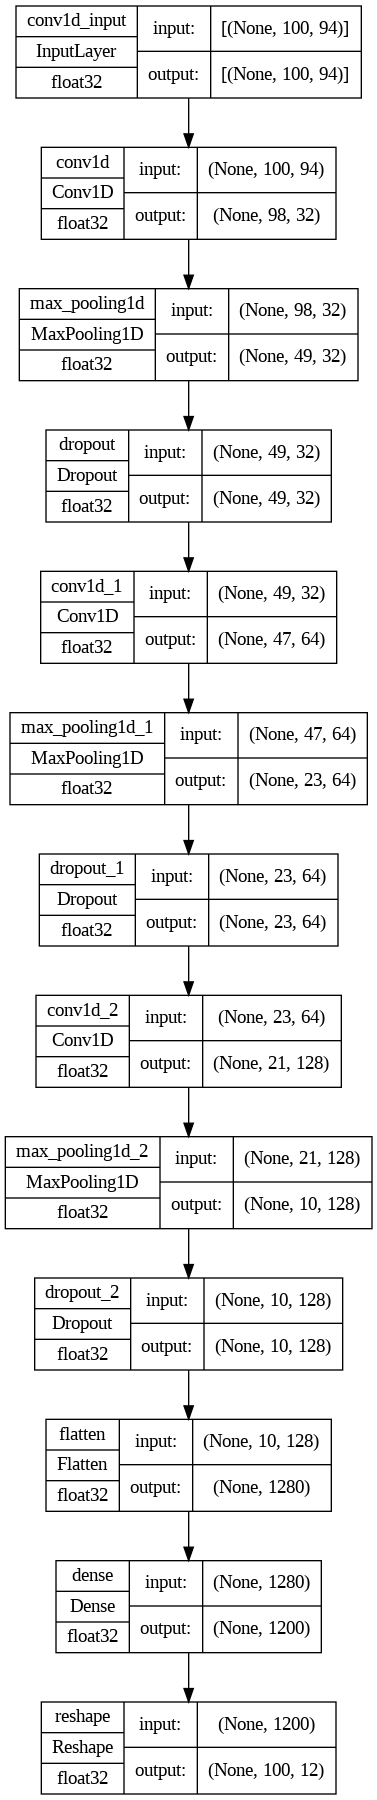

In [39]:
keras.utils.plot_model(model,show_shapes=True, show_dtype=True)

In [40]:
epochs=20
history=model.fit(train_gen,validation_data=val_gen,epochs=epochs)

Epoch 1/20
2741/2741 [==============================] - 59s 16ms/step - loss: 0.6320 - accuracy: 0.7593 - val_loss: 0.4815 - val_accuracy: 0.8100
Epoch 2/20
2741/2741 [==============================] - 40s 15ms/step - loss: 0.3775 - accuracy: 0.8514 - val_loss: 0.4159 - val_accuracy: 0.8392
Epoch 3/20
2741/2741 [==============================] - 38s 14ms/step - loss: 0.3228 - accuracy: 0.8715 - val_loss: 0.3771 - val_accuracy: 0.8546
Epoch 4/20
2741/2741 [==============================] - 38s 14ms/step - loss: 0.2938 - accuracy: 0.8821 - val_loss: 0.3648 - val_accuracy: 0.8584
Epoch 5/20
2741/2741 [==============================] - 39s 14ms/step - loss: 0.2771 - accuracy: 0.8886 - val_loss: 0.3516 - val_accuracy: 0.8653
Epoch 6/20
2741/2741 [==============================] - 39s 14ms/step - loss: 0.2626 - accuracy: 0.8938 - val_loss: 0.3337 - val_accuracy: 0.8721
Epoch 7/20
2741/2741 [==============================] - 38s 14ms/step - loss: 0.2544 - accuracy: 0.8968 - val_loss: 0.3335 -

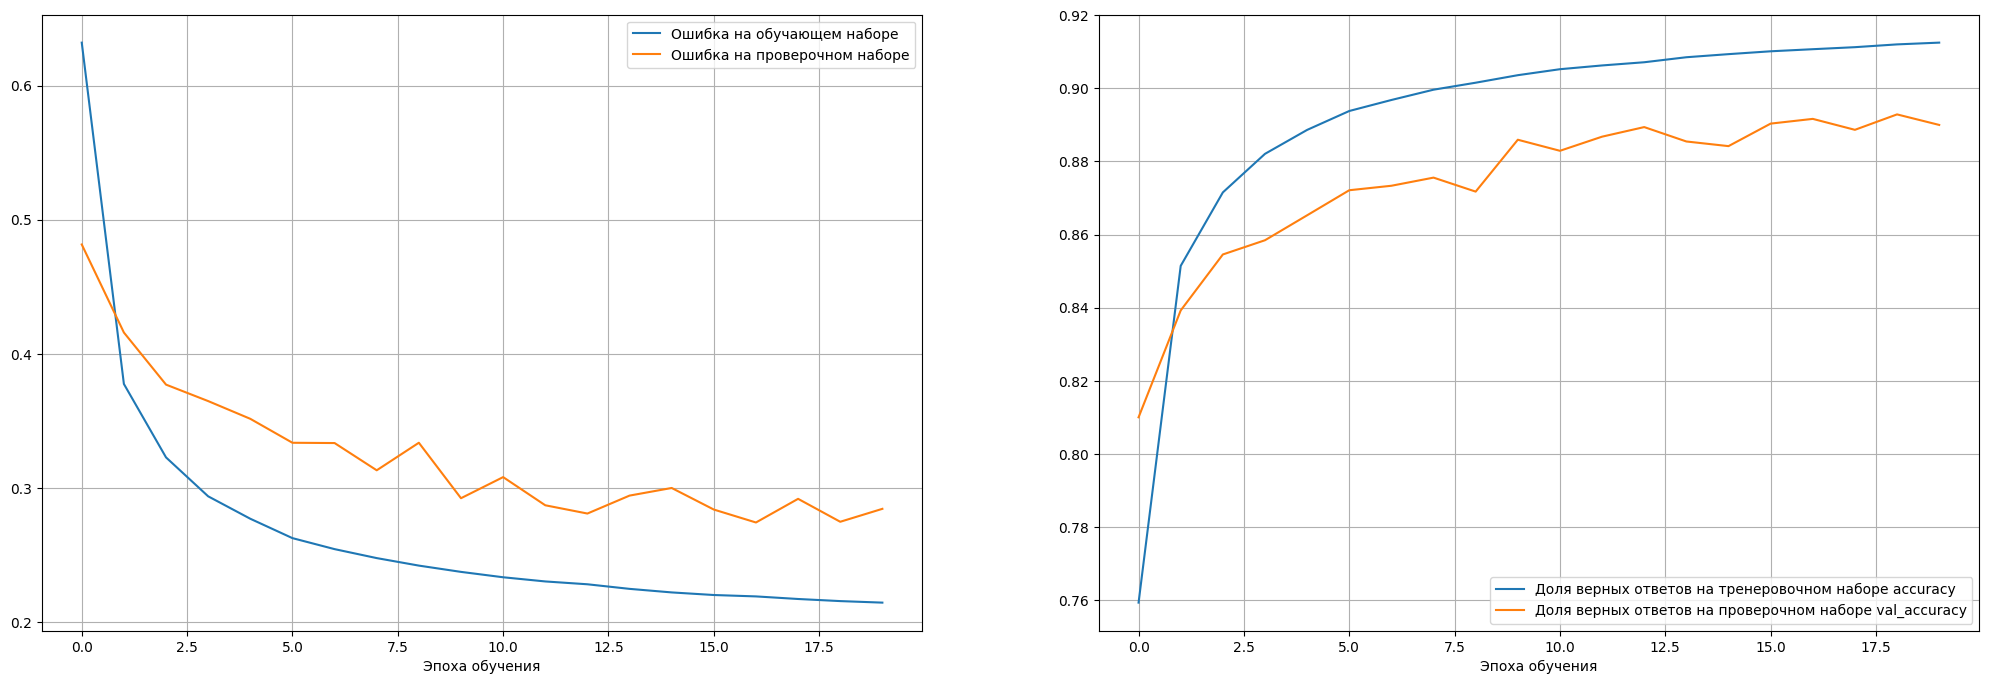

In [41]:
show_charts(history.history)

In [51]:
NetName='3Conv_aug'
model.save(os.path.join(ModelSavePath, NetName)) # Сохраняем модель

#Эксперименты с моделью

In [43]:
model=load_model(os.path.join(ModelSavePath, NetName)) # Загружаем сохраненную модель

##'Максим УЧИ УКЕ из валидационной выборки

In [42]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Максим УЧИ УКЕ (корпус шомен 2)'
df_test=df[df['filename']==file_name].sort_values('frame#')
df_test

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
filename,,,,,,,,,,,,,,,,,,,,,
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,0.330736,0.310105,0.628965,-0.290434,-0.584240,0.002595,-0.865620,0.468695,-0.185726,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,0.441439,-0.042722,0.012610,0.004526,-0.464617,0.052453,-0.480372,0.099168,-0.380669,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,0.767550,-0.554400,-0.072838,-0.411798,-0.806259,0.359514,0.179970,-0.296665,0.181280,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,-0.055854,-0.349107,0.915040,-0.515288,0.986352,0.971484,-0.718204,0.975001,0.299657,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,0.856731,0.770085,0.885913,0.278972,-0.327188,-0.507441,0.163824,0.740431,0.258750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,-0.436769,-0.796146,0.646203,0.063755,-0.154400,0.653070,0.015041,0.976333,-0.553768,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,-0.232748,0.816122,0.065627,0.101830,-0.833159,0.676867,-0.531895,0.059177,0.264150,1
Максим УЧИ УКЕ (корпус шомен 2),0,0,0,0,0,0,0,0,0,0,...,0.978450,0.152584,-0.358650,-0.347636,-0.421347,-0.563831,0.658188,0.596123,-0.597900,1


In [43]:
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'

correct=wrong main_folder=УЧИ УКЕ (БЛОК ПЕРЕДНЕЙ РУКОЙ) folder=side


In [44]:
result=predict(model,df_test,x_column_list)
result.shape

(572, 12)

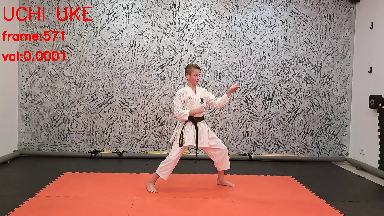

Обработано 571 кадров
Всего обработано 572 кадров


In [45]:
mark_move(result,VideoPathIn,VideoPathOut)

##Андрей КИДЗАМИ ДЗУКИ (с низу в верх 2)И из валидационной выборки

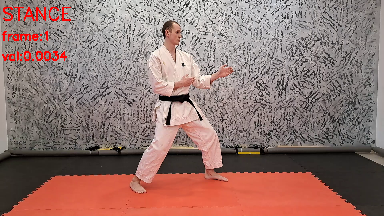

Обработано 1 кадров


In [ ]:
#пробуем предиктить на видео, которые сеть не видела (из валидационной выборки)
file_name='Андрей КИДЗАМИ ДЗУКИ (с низу в верх 2)'
df_test=df[df['filename']==file_name].sort_values('frame#')
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
mark_move(result,VideoPathIn,VideoPathOut)

## Примеры из тестового датасета 2308

In [46]:
df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/dataset_test_all_features_phase.csv')
#df_2308=pd.read_csv('/content/drive/MyDrive/internship/karate/dataset/dataset__all_features_phase.csv')
#Оставим только размеченные данные
df_2308=df_2308[df_2308['phase']>0]
#Посмотрим список размеченных на данный момент ударов файлов
#Посмотрим список файлов и ударов, которые есть в размеченном датасете
kick_list=np.unique(df_2308['main_folder'])
print(f'Размеченные удары: {kick_list}')
total_file_list=[]
for kick in kick_list:
  file_list=np.unique(df_2308.loc[df_2308['main_folder']==kick,'filename'])
  print (f'для удара {kick} размечены файлы {file_list} \r\n Всего: {len(file_list)} файлов',sep=',')
  #total_file_list.extend(file_list)

Размеченные удары: ['ГЕДАН БАРАЙ' 'МАВАШИ ГЕРИ' 'УРА МАВАШИ ГЕРИ' 'УРАКЕН УЧИ' 'УЧИ УКЕ']
для удара ГЕДАН БАРАЙ размечены файлы ['20230814_171314' '20230814_171717' 'не верный замах'
 'не верный замах 2'] 
 Всего: 4 файлов
для удара МАВАШИ ГЕРИ размечены файлы ['20230816_170111' '20230816_170212' 'нет поворота на опорной ноге '
 'нет поворота на опорной ноге 2'] 
 Всего: 4 файлов
для удара УРА МАВАШИ ГЕРИ размечены файлы ['20230816_170520' '20230816_170605' 'нет замаха' 'нет замаха 2'] 
 Всего: 4 файлов
для удара УРАКЕН УЧИ размечены файлы ['20230814_172421' '20230814_172449' 'перекрут корпуса'
 'перекрут корпуса 2'] 
 Всего: 4 файлов
для удара УЧИ УКЕ размечены файлы ['20230814_170227' '20230814_170528' 'перекрут корпуса'
 'перекрут корпуса 2'] 
 Всего: 4 файлов


### Расчет точности на тестовой выборке

In [47]:
#Подготовка датасета
#Добавим к датасету еще 2 класса (10 - стойка, 11 - Прочее (возвраты и т.д))
df_2308.insert(10,'10',np.zeros(len(df_2308)))
df_2308.insert(11,'11',np.zeros(len(df_2308)))
#заполним столбец для стойки и возврата
df_2308.loc[df_2308['phase']==1,'10']=1 #стойка
df_2308.loc[df_2308['phase']==3,'11']=1 #прочее
#остальные метки обнулить
df_2308.loc[df_2308['phase']==1,['0','1','2','3','4','5','6','7','8','9']]=0
df_2308.loc[df_2308['phase']==3,['0','1','2','3','4','5','6','7','8','9']]=0

In [48]:
df_2308

,0,1,2,3,4,5,6,7,8,9,...,o23_25_OY,o23_25_OX,o23_25_OZ,o26_28_OY,o26_28_OX,o26_28_OZ,o25_27_OY,o25_27_OX,o25_27_OZ,phase
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.741920,0.468273,-0.479870,0.676870,-0.412263,0.609825,0.783959,-0.031655,0.620005,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.791954,0.488757,-0.365957,0.665724,-0.393299,0.634135,0.766725,-0.040097,0.640722,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.835179,0.503657,-0.220919,0.677565,-0.395949,0.619782,0.757250,-0.042381,0.651749,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.846463,0.501879,-0.177812,0.682022,-0.394545,0.615776,0.753382,-0.044392,0.656083,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.829634,0.492157,-0.263608,0.694177,-0.404641,0.595302,0.758167,-0.046083,0.650430,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.881086,0.041956,-0.471091,0.669279,0.105047,0.735547,0.979013,0.201331,-0.031626,1
38869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.870914,0.039754,-0.489825,0.671248,0.104099,0.733887,0.979131,0.201096,-0.029376,1
38870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.911448,0.041536,-0.409314,0.719681,0.103838,0.686496,0.975107,0.200927,-0.093785,1
38871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.899374,0.042934,-0.435067,0.673915,0.097009,0.732413,0.978361,0.200410,-0.051440,1


In [49]:
for file in file_list:
  df_test=df_2308[df_2308['filename']==file].sort_values('frame#')
  df_test=df_test[df_test['frame#']%2==0]
  #Зашумляем улы ног для верхних ударов
  for column in ignor_angles:
      # Фильтруем строки, где значение в столбце 'mainfolder' соответствует 'upper_kicks'
      mask = df_test['main_folder'].isin(upper_kicks)
      df_test.loc[mask, column] = np.random.uniform(-1, 1, size=np.sum(mask))

  Y_test=np.argmax(df_test[y_column_list].values,axis=1)
  result=np.argmax(predict(model,df_test,x_column_list),axis=1)
  print (np.unique(Y_test), np.unique(result))
  m=Accuracy()
  m.update_state(Y_test, result)
  print (f'Файл "{file}" содержит {len(df_test)} кадров. Точность предсказания: {m.result().numpy():.2f}' )




[ 9 10 11] [ 4  7 10 11]
Файл "20230814_170227" содержит 634 кадров. Точность предсказания: 0.44
[ 9 10 11] [ 4  7 10 11]
Файл "20230814_170528" содержит 629 кадров. Точность предсказания: 0.34
[ 8  9 10 11] [ 0  4  7  8 10 11]
Файл "перекрут корпуса" содержит 1360 кадров. Точность предсказания: 0.46
[ 8  9 10 11] [ 4  7 10 11]
Файл "перекрут корпуса 2" содержит 1370 кадров. Точность предсказания: 0.29


###Файл из тестового датасета 20230814_171314

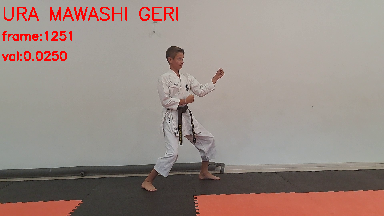

Обработано 1251 кадров
Всего обработано 1257 кадров


In [50]:
file_name='20230814_170528' #УЧИ УКЕ
df_test=df_2308[df_2308['filename']==file_name].sort_values('frame#')
mask = df_test['main_folder'].isin(upper_kicks)
df_test.loc[mask, column] = np.random.uniform(-1, 1, size=np.sum(mask))
correct=df_test.correct.iloc[0]
main_folder=df_test.main_folder.iloc[0]
folder=df_test.folder.iloc[0]
print(f'correct={correct} main_folder={main_folder} folder={folder}')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/{correct}/{main_folder}/{folder}/{file_name}.mp4'
VideoPathOut=f'/content/{file_name} Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
mark_move(result,VideoPathIn,VideoPathOut)

##Ката

In [ ]:
#пробуем предиктить на видео ката
df_test=pd.read_csv('/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/dataset_ката_all_features.csv')

VideoPathIn=f'/content/drive/MyDrive/internship/karate/karate Lena/test_dataset/ката/ката центральная камера.mp4'
VideoPathOut=f'/content/ката_Marked_v2.mp4'
result=predict(model,df_test,x_column_list)
#result[np.where(np.max(result,axis=1)<0.01)][:,11]=1 #Если уверенность меньше порога, считаем что это класс неизвестно
mark_move(result,VideoPathIn,VideoPathOut)